In [13]:
import polars as pl
import time

start_time = time.perf_counter()

# Load CSV file
df = pl.read_csv("/Users/prabhushankar/Downloads/BDHSC_SCC_2025_synth_data.csv", dtypes={"ID": pl.Utf8})

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f' The it took to run the query is {elapsed_time} seconds ' )

df['ID'].unique()

/var/folders/wc/wf8d41213dxfd0jz8k4gpjlr0000gn/T/ipykernel_62220/872457545.py:7: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  df = pl.read_csv("/Users/prabhushankar/Downloads/BDHSC_SCC_2025_synth_data.csv", dtypes={"ID": pl.Utf8})


 The it took to run the query is 2.857453666976653 seconds 


ID
str
"""17949474093040554827"""
"""3206454361022842488"""
"""4496198483924006749"""
"""7636500104699684087"""
"""6005826935631742582"""
…
"""6957133540404888310"""
"""16818631476014213645"""
"""14416946420685054308"""


In [3]:


# Assuming df is your Polars DataFrame
drug_distribution = (
    df.group_by(["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"])
    .agg(pl.col("ID").n_unique().alias("Patient_Count"))
    .sort("Patient_Count", descending=True)  # Sort by most common regimens
)
drug_distribution

Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,Patient_Count
i64,i64,i64,i64,i64,u32
0,3,2,5,0,68523
1,0,3,5,0,51366
0,3,1,5,0,48237
3,3,3,1,0,36645
0,0,3,5,0,26628
…,…,…,…,…,…
2,2,3,4,1,21
2,2,3,0,0,21
3,2,2,5,1,21


In [4]:
patient_regimen_changes = (
    df.group_by("ID")
    .agg(
        pl.struct(["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"])
        .unique()
        .count()
        .alias("Unique_Regimens")
    )
    .filter(pl.col("Unique_Regimens") > 1)  # Filter patients with more than 1 unique regimen
)
patient_regimen_changes

ID,Unique_Regimens
str,u32
"""15791671157670126174""",2
"""12734381574582924932""",7
"""9633531806606070496""",8
"""9771506276302457785""",2
"""13204638292342463796""",2
…,…
"""9147343366549359111""",6
"""3443625057407121205""",3
"""7629750966817986248""",5


In [5]:
viral_suppression = (
    df.group_by("ID").agg([
        pl.col("Month").filter(pl.col("VL") <= 250).min().alias("First_VL_250"),
        pl.col("Month").filter(pl.col("VL") <= 50).min().alias("First_VL_50"),
        pl.col("Month").filter(pl.col("CD4") >= 500).min().alias("First_CD4_500")
    ])
)
viral_suppression

ID,First_VL_250,First_VL_50,First_CD4_500
str,i64,i64,i64
"""7383413462968028800""",14,35,5
"""16513942501213215386""",6,37,0
"""9596570022981351632""",37,37,0
"""5782266317543910517""",36,36,0
"""2338224216254115899""",6,6,0
…,…,…,…
"""131109144855257438""",11,37,0
"""11210615490235162055""",12,16,0
"""12968173266737491714""",12,25,0


In [6]:
regimen_effectiveness = (
    df.join(viral_suppression, on="ID", how="left")
    .group_by(["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"])
    .agg(
        pl.col("First_VL_250").mean().alias("Avg_Time_VL_250"),
        pl.col("First_VL_50").mean().alias("Avg_Time_VL_50"),
        pl.col("First_CD4_500").mean().alias("Avg_Time_CD4_500"),
        pl.col("ID").n_unique().alias("Patient_Count")
    )
    .sort("Avg_Time_VL_50")  # Sort by fastest viral suppression
)
regimen_effectiveness

Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,Avg_Time_VL_250,Avg_Time_VL_50,Avg_Time_CD4_500,Patient_Count
i64,i64,i64,i64,i64,f64,f64,f64,u32
1,3,3,3,0,0.026217,0.862493,3.286893,567
5,3,0,0,0,1.5,3.0,5.0,63
1,3,3,4,0,1.660466,3.213638,2.7643,4725
5,3,2,0,0,3.022501,3.252747,11.118421,147
1,3,3,2,0,2.841571,4.003611,1.191388,1365
…,…,…,…,…,…,…,…,…
2,1,3,5,1,37.0,37.0,0.0,21
1,1,3,5,1,36.972973,37.243243,0.0,126
3,3,2,4,0,37.0,37.857143,0.0,63


In [7]:
regimen_effectiveness = regimen_effectiveness.with_columns(
    pl.when(pl.col("Avg_Time_VL_50") <= 6)
      .then(pl.lit("Fast Suppression"))
      .when(pl.col("Avg_Time_VL_50") <= 24)
      .then(pl.lit("Moderate Suppression"))
      .otherwise(pl.lit("Slow Suppression"))
      .alias("Suppression_Category")
)
regimen_effectiveness


Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,Avg_Time_VL_250,Avg_Time_VL_50,Avg_Time_CD4_500,Patient_Count,Suppression_Category
i64,i64,i64,i64,i64,f64,f64,f64,u32,str
1,3,3,3,0,0.026217,0.862493,3.286893,567,"""Fast Suppression"""
5,3,0,0,0,1.5,3.0,5.0,63,"""Fast Suppression"""
1,3,3,4,0,1.660466,3.213638,2.7643,4725,"""Fast Suppression"""
5,3,2,0,0,3.022501,3.252747,11.118421,147,"""Fast Suppression"""
1,3,3,2,0,2.841571,4.003611,1.191388,1365,"""Fast Suppression"""
…,…,…,…,…,…,…,…,…,…
2,1,3,5,1,37.0,37.0,0.0,21,"""Slow Suppression"""
1,1,3,5,1,36.972973,37.243243,0.0,126,"""Slow Suppression"""
3,3,2,4,0,37.0,37.857143,0.0,63,"""Slow Suppression"""


In [8]:
regimen_effectiveness.write_csv("regimen.csv")

In [9]:
patient_distribution = (
    regimen_effectiveness.group_by("Suppression_Category")
    .agg(
        pl.col("Patient_Count").sum().alias("Total_Patients")
    )
    .sort("Total_Patients", descending=True)  # Sort by Total_Patients in descending order
)
patient_distribution

Suppression_Category,Total_Patients
str,u32
"""Moderate Suppression""",393960
"""Slow Suppression""",68208
"""Fast Suppression""",55482


In [10]:
patient_regimen_changes = (
    df.group_by("ID")
    .agg(
        pl.struct(["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"])
        .unique()
        .count()
        .alias("Unique_Regimens")
    )
    .filter(pl.col("Unique_Regimens") > 1)  # Keep only patients with more than 1 unique regimen
    .select("ID")  # Extract only the Patient_ID column
    .to_series()  # Convert to a Series (equivalent to `pull()` in dplyr)
)
patient_regimen_changes

ID
str
"""6174780774152393722"""
"""11255484168311151306"""
"""3731092474428722694"""
"""7834266247074563717"""
"""1802785353795914031"""
…
"""8993927349340331979"""
"""7162176985585786769"""
"""14782227150837613919"""


In [11]:
suppression_data = (
    df.group_by("ID")
    .agg(
        pl.col("Month").filter(pl.col("VL") <= 250).min().alias("First_VL_250"),
        pl.col("Month").filter(pl.col("VL") <= 50).min().alias("First_VL_50"),
        pl.col("Month").filter(pl.col("CD4") >= 500).min().alias("First_CD4_500")
    )
    .with_columns(
        (pl.col("First_VL_250") <= 6).fill_null(False).map_elements(lambda x: "Yes" if x else "No").alias("VL less than 250 within 6 months"),
        (pl.col("First_VL_50") <= 12).fill_null(False).map_elements(lambda x: "Yes" if x else "No").alias("VL less than 60 within 12 months"),
        (pl.col("First_CD4_500") <= 24).fill_null(False).map_elements(lambda x: "Yes" if x else "No").alias("CD4 Count greater than 500 within 24 months")
    )
    .select(["ID", "VL less than 250 within 6 months", "VL less than 60 within 12 months", "CD4 Count greater than 500 within 24 months"])
)
suppression_data

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


ID,VL less than 250 within 6 months,VL less than 60 within 12 months,CD4 Count greater than 500 within 24 months
str,str,str,str
"""15430921406307017359""","""No""","""No""","""Yes"""
"""16235467586047301353""","""No""","""No""","""Yes"""
"""14563912293818742889""","""Yes""","""Yes""","""Yes"""
"""2492286676938457414""","""No""","""No""","""Yes"""
"""11828734763832412095""","""Yes""","""Yes""","""Yes"""
…,…,…,…
"""15406868102019743207""","""Yes""","""Yes""","""Yes"""
"""14035659624029201800""","""Yes""","""Yes""","""Yes"""
"""7583376106952734371""","""Yes""","""Yes""","""Yes"""


In [12]:
# Select relevant columns and keep unique Patient-Regimen pairs
final_table = (
    df.select(["ID", "Gender", "Ethnic", "Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"])
    .unique()  # Equivalent to distinct() in dplyr
)

# Filter: Keep all rows for patients who changed regimens, else keep the first occurrence
final_table = final_table.filter(
    pl.col("ID").is_in(patient_regimen_changes) | ~pl.col("ID").is_duplicated()
)

# Left join with suppression_data on Patient_ID
final_table = final_table.join(suppression_data, on="ID", how="left")

final_table

ID,Gender,Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,VL less than 250 within 6 months,VL less than 60 within 12 months,CD4 Count greater than 500 within 24 months
str,i64,i64,i64,i64,i64,i64,i64,str,str,str
"""17488760435271548988""",1,4,0,3,2,5,0,"""No""","""No""","""Yes"""
"""14098641293179795513""",1,4,1,0,3,5,0,"""Yes""","""No""","""Yes"""
"""13353909637949978659""",1,4,0,2,3,5,1,"""No""","""Yes""","""Yes"""
"""2915616291018843263""",2,3,1,3,3,0,0,"""Yes""","""Yes""","""Yes"""
"""143057030681215354""",1,4,0,3,2,5,0,"""Yes""","""Yes""","""Yes"""
…,…,…,…,…,…,…,…,…,…,…
"""3396950583161209948""",1,3,0,3,1,5,0,"""Yes""","""Yes""","""Yes"""
"""6342402611855677974""",1,4,3,3,3,0,0,"""Yes""","""Yes""","""Yes"""
"""14097795742850768820""",1,3,2,0,3,5,0,"""No""","""No""","""Yes"""


In [13]:

final_table = final_table.with_columns(
    ( 
        (pl.col("VL less than 250 within 6 months") == "Yes") & 
        (pl.col("VL less than 60 within 12 months") == "Yes") & 
        (pl.col("CD4 Count greater than 500 within 24 months") == "Yes")
    )
    .map_elements(lambda x: "Yes" if x else "No")
    .alias("Regimen Effectiveness")
)

final_table


/var/folders/wc/wf8d41213dxfd0jz8k4gpjlr0000gn/T/ipykernel_49415/3090567628.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  final_table = final_table.with_columns(


ID,Gender,Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,VL less than 250 within 6 months,VL less than 60 within 12 months,CD4 Count greater than 500 within 24 months,Regimen Effectiveness
str,i64,i64,i64,i64,i64,i64,i64,str,str,str,str
"""17488760435271548988""",1,4,0,3,2,5,0,"""No""","""No""","""Yes""","""No"""
"""14098641293179795513""",1,4,1,0,3,5,0,"""Yes""","""No""","""Yes""","""No"""
"""13353909637949978659""",1,4,0,2,3,5,1,"""No""","""Yes""","""Yes""","""No"""
"""2915616291018843263""",2,3,1,3,3,0,0,"""Yes""","""Yes""","""Yes""","""Yes"""
"""143057030681215354""",1,4,0,3,2,5,0,"""Yes""","""Yes""","""Yes""","""Yes"""
…,…,…,…,…,…,…,…,…,…,…,…
"""3396950583161209948""",1,3,0,3,1,5,0,"""Yes""","""Yes""","""Yes""","""Yes"""
"""6342402611855677974""",1,4,3,3,3,0,0,"""Yes""","""Yes""","""Yes""","""Yes"""
"""14097795742850768820""",1,3,2,0,3,5,0,"""No""","""No""","""Yes""","""No"""


In [14]:
effectiveness_summary = (
    final_table.group_by("Regimen Effectiveness")
    .agg(
        pl.len().alias("Total")  # Count number of rows in each group
    )
)

print(effectiveness_summary)

shape: (2, 2)
┌───────────────────────┬────────┐
│ Regimen Effectiveness ┆ Total  │
│ ---                   ┆ ---    │
│ str                   ┆ u32    │
╞═══════════════════════╪════════╡
│ Yes                   ┆ 172194 │
│ No                    ┆ 345456 │
└───────────────────────┴────────┘


In [14]:
effectiveness_by_regimen = (
    final_table.group_by(["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"])
    .agg(
        (pl.col("Regimen Effectiveness") == "Yes").mean().alias("Success_Rate"),  # Compute mean of boolean conversion
        pl.len().alias("Total_Patients")  # Count total patients in each regimen group
    )
    .sort("Success_Rate", descending=True)  # Sort by highest success rate
)

print(effectiveness_by_regimen)

shape: (135, 7)
┌─────────────────┬──────────┬────────────┬─────────┬────────────┬──────────────┬────────────────┐
│ Base_Drug_Combo ┆ Comp_INI ┆ Comp_NNRTI ┆ ExtraPI ┆ ExtraPk_En ┆ Success_Rate ┆ Total_Patients │
│ ---             ┆ ---      ┆ ---        ┆ ---     ┆ ---        ┆ ---          ┆ ---            │
│ i64             ┆ i64      ┆ i64        ┆ i64     ┆ i64        ┆ f64          ┆ u32            │
╞═════════════════╪══════════╪════════════╪═════════╪════════════╪══════════════╪════════════════╡
│ 2               ┆ 3        ┆ 2          ┆ 0       ┆ 1          ┆ 1.0          ┆ 63             │
│ 5               ┆ 3        ┆ 0          ┆ 0       ┆ 0          ┆ 1.0          ┆ 63             │
│ 5               ┆ 1        ┆ 3          ┆ 5       ┆ 0          ┆ 1.0          ┆ 21             │
│ 0               ┆ 0        ┆ 3          ┆ 2       ┆ 0          ┆ 1.0          ┆ 21             │
│ 5               ┆ 3        ┆ 3          ┆ 2       ┆ 0          ┆ 1.0          ┆ 126        

In [15]:
effectiveness_by_gender = (
    final_table.group_by(["Gender", "Regimen Effectiveness"])
    .agg(pl.len().alias("Count"))  # Count occurrences
    .pivot(
        values="Count",
        index="Gender",
        columns="Regimen Effectiveness",
        aggregate_function="first"
    )
    .fill_null(0)  # Fill missing values with 0
)

print(effectiveness_by_gender)

shape: (2, 3)
┌────────┬────────┬────────┐
│ Gender ┆ Yes    ┆ No     │
│ ---    ┆ ---    ┆ ---    │
│ i64    ┆ u32    ┆ u32    │
╞════════╪════════╪════════╡
│ 2      ┆ 29302  ┆ 47789  │
│ 1      ┆ 142892 ┆ 297667 │
└────────┴────────┴────────┘


/var/folders/wc/wf8d41213dxfd0jz8k4gpjlr0000gn/T/ipykernel_48318/3689593933.py:4: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


In [16]:
effectiveness_by_ethnicity = (
    final_table.group_by(["Ethnic", "Regimen Effectiveness"])
    .agg(pl.len().alias("Count"))  # Count occurrences
    .pivot(
        values="Count",
        index="Ethnic",
        columns="Regimen Effectiveness",
        aggregate_function="first"
    )
    .fill_null(0)  # Fill missing values with 0
)

print(effectiveness_by_ethnicity)

shape: (4, 3)
┌────────┬───────┬────────┐
│ Ethnic ┆ Yes   ┆ No     │
│ ---    ┆ ---   ┆ ---    │
│ i64    ┆ u32   ┆ u32    │
╞════════╪═══════╪════════╡
│ 1      ┆ 6887  ┆ 526    │
│ 2      ┆ 24564 ┆ 36210  │
│ 3      ┆ 68809 ┆ 54797  │
│ 4      ┆ 71934 ┆ 253923 │
└────────┴───────┴────────┘


/var/folders/wc/wf8d41213dxfd0jz8k4gpjlr0000gn/T/ipykernel_48318/931759704.py:4: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


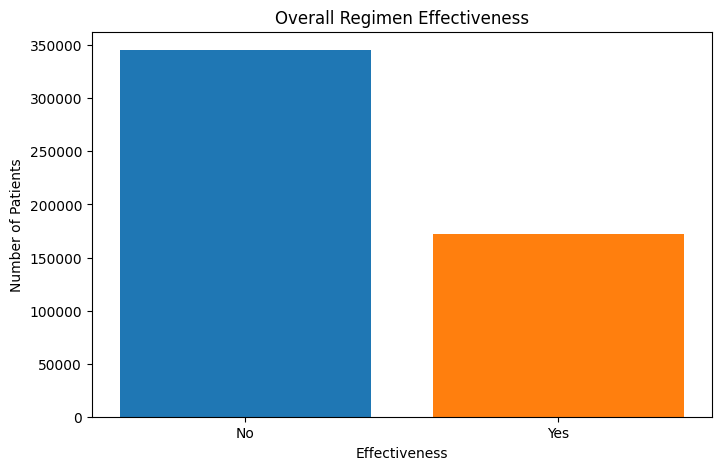

In [17]:
import matplotlib.pyplot as plt

# Convert Polars DataFrame to Pandas for plotting
df_plot = effectiveness_summary.to_pandas()

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_plot["Regimen Effectiveness"], df_plot["Total"], color=["#1f77b4", "#ff7f0e"])  # Customize colors if needed

# Labels and title
plt.xlabel("Effectiveness")
plt.ylabel("Number of Patients")
plt.title("Overall Regimen Effectiveness")

# Show the plot
plt.show()


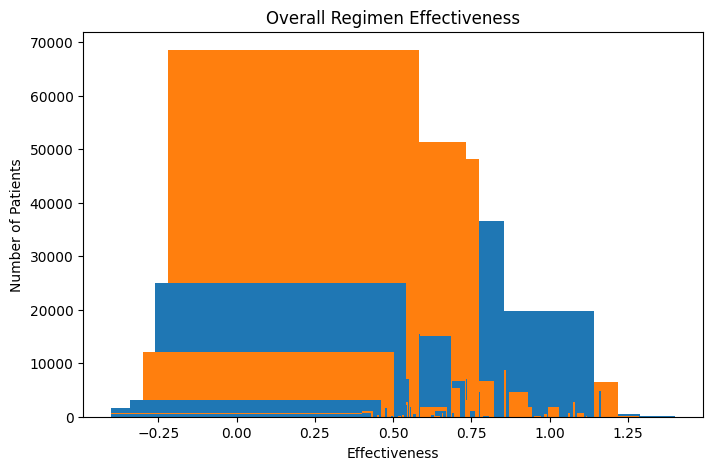

In [18]:
import matplotlib.pyplot as plt

# Convert Polars DataFrame to Pandas for plotting
df_plot = effectiveness_by_regimen.to_pandas()

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_plot["Success_Rate"], df_plot["Total_Patients"], color=["#1f77b4", "#ff7f0e"])  # Customize colors if needed

# Labels and title
plt.xlabel("Effectiveness")
plt.ylabel("Number of Patients")
plt.title("Overall Regimen Effectiveness")

# Show the plot
plt.show()


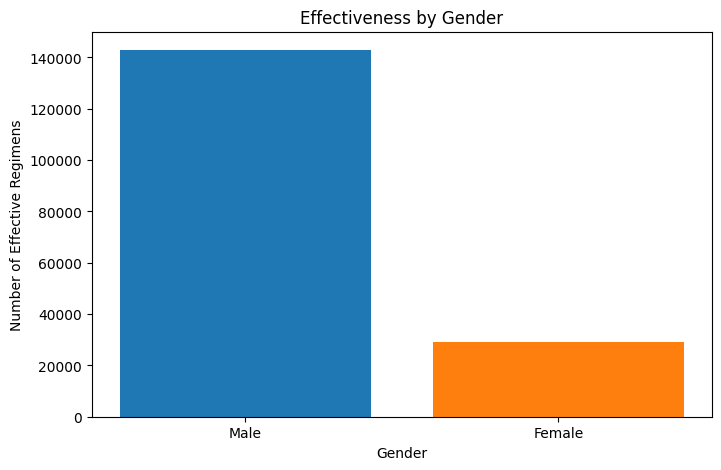

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Manually create the dataframe based on the provided data
data = {
    "Gender": ["Male", "Female"],  # Assuming 1 = Male, 2 = Female
    "Yes": [142892, 29302],  # Number of effective regimens
}

# Convert to Pandas DataFrame
df_plot = pd.DataFrame(data)

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_plot["Gender"], df_plot["Yes"], color=["#1f77b4", "#ff7f0e"])  # Custom colors for Male and Female

# Labels and title
plt.xlabel("Gender")
plt.ylabel("Number of Effective Regimens")
plt.title("Effectiveness by Gender")

# Show the plot
plt.show()


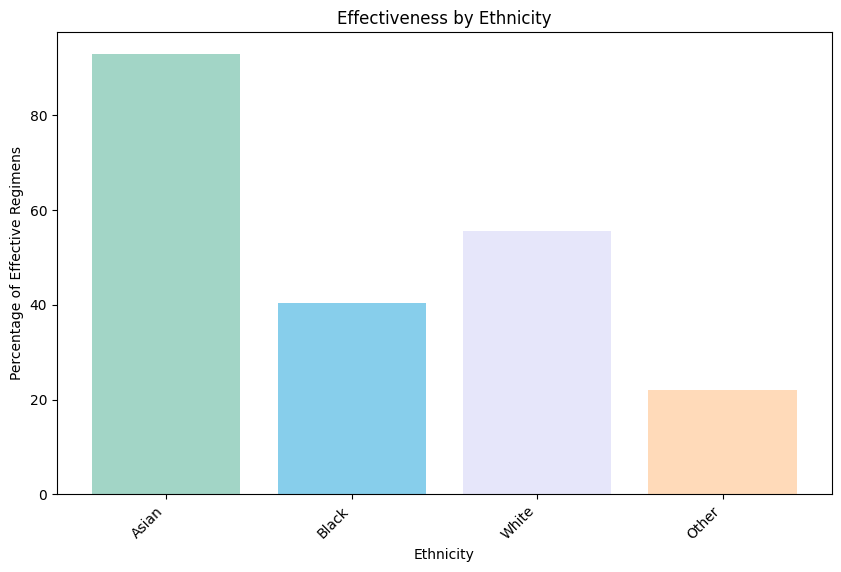

In [20]:
# Sample data for effectiveness by ethnicity (Replace with actual data if available)
data_ethnicity = {
    "Ethnic": ["Asian", "Black", "White", "Other"],  # Example ethnic groups
    "Yes": [92.9, 40.4, 55.6, 22.0],  # Number of effective regimens
}

# Convert to Pandas DataFrame
df_ethnicity = pd.DataFrame(data_ethnicity)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_ethnicity["Ethnic"], df_ethnicity["Yes"], color = ["#A2D5C6", "#87CEEB", "#E6E6FA", "#FFDAB9"])  # Custom colors

# Labels and title
plt.xlabel("Ethnicity")
plt.ylabel("Percentage of Effective Regimens")
plt.title("Effectiveness by Ethnicity")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

plt.savefig('chart.png')
# Show the plot
plt.show()


In [28]:
joined_df = suppression_data.join(df, on="ID", how="left")
joined_df

ID,VL less than 250 within 6 months,VL less than 60 within 12 months,CD4 Count greater than 500 within 24 months,Month,Gender,Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,VL_M,CD4_M,Drug_M,VL,CD4,RelCD4
str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",0,1,2,3,3,3,3,0,1,1,1,203.26554,1111.531161,25.865305
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",1,1,2,3,3,3,3,0,0,0,1,217.690727,787.390787,42.567234
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",2,1,2,3,3,3,3,0,0,0,1,67.264792,740.202687,39.385078
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",3,1,2,3,3,3,3,0,0,1,1,223.452455,933.331695,33.887889
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",4,1,2,3,3,3,3,0,0,0,1,84.965101,754.340439,46.630369
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""13150549226139536745""","""No""","""No""","""Yes""",55,1,4,0,3,2,5,0,0,0,1,23.305458,310.975953,16.430768
"""13150549226139536745""","""No""","""No""","""Yes""",56,1,4,0,3,2,5,0,0,1,1,62.478231,280.314656,15.265358
"""13150549226139536745""","""No""","""No""","""Yes""",57,1,4,0,3,2,5,0,0,0,1,21.632324,426.414475,15.988145


In [29]:
joined_df = joined_df.with_columns(
    pl.when(
        (pl.col("VL less than 250 within 6 months") == "Yes") &
        (pl.col("VL less than 60 within 12 months") == "Yes") &
        (pl.col("CD4 Count greater than 500 within 24 months") == "Yes")
    )
    .then(pl.lit(1))
    .otherwise(pl.lit(2))
    .alias("All Criteria Met")
)

joined_df

ID,VL less than 250 within 6 months,VL less than 60 within 12 months,CD4 Count greater than 500 within 24 months,Month,Gender,Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,VL_M,CD4_M,Drug_M,VL,CD4,RelCD4,All Criteria Met
str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i32
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",0,1,2,3,3,3,3,0,1,1,1,203.26554,1111.531161,25.865305,1
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",1,1,2,3,3,3,3,0,0,0,1,217.690727,787.390787,42.567234,1
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",2,1,2,3,3,3,3,0,0,0,1,67.264792,740.202687,39.385078,1
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",3,1,2,3,3,3,3,0,0,1,1,223.452455,933.331695,33.887889,1
"""5182659397319460289""","""Yes""","""Yes""","""Yes""",4,1,2,3,3,3,3,0,0,0,1,84.965101,754.340439,46.630369,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""13150549226139536745""","""No""","""No""","""Yes""",55,1,4,0,3,2,5,0,0,0,1,23.305458,310.975953,16.430768,2
"""13150549226139536745""","""No""","""No""","""Yes""",56,1,4,0,3,2,5,0,0,1,1,62.478231,280.314656,15.265358,2
"""13150549226139536745""","""No""","""No""","""Yes""",57,1,4,0,3,2,5,0,0,0,1,21.632324,426.414475,15.988145,2


In [30]:
joined_df = joined_df.with_columns(
    pl.arange(1, df.height + 1).alias("Serial Number")
)

In [31]:

joined_df = joined_df.drop('VL less than 250 within 6 months')
joined_df = joined_df.drop('VL less than 60 within 12 months')
joined_df = joined_df.drop('CD4 Count greater than 500 within 24 months')
joined_df = joined_df.drop('VL_M')
joined_df = joined_df.drop('CD4_M')
joined_df = joined_df.drop('Drug_M') 
joined_df = joined_df.drop('RelCD4')

joined_df = joined_df.drop('ID')
joined_df = joined_df.drop('VL')
joined_df = joined_df.drop('CD4')
joined_df = joined_df.drop('Gender')
joined_df = joined_df.drop('Month')

joined_df

Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,All Criteria Met,Serial Number
i64,i64,i64,i64,i64,i64,i32,i64
2,3,3,3,3,0,1,1
2,3,3,3,3,0,1,2
2,3,3,3,3,0,1,3
2,3,3,3,3,0,1,4
2,3,3,3,3,0,1,5
…,…,…,…,…,…,…,…
4,0,3,2,5,0,2,11234156
4,0,3,2,5,0,2,11234157
4,0,3,2,5,0,2,11234158


In [32]:

train_fraction = 0.8  # 80% train, 20% test

# Create the training set
train_df = joined_df.sample(fraction=train_fraction, shuffle=True, seed=42)

# Create the test set (exclude the train samples)
test_df = joined_df.filter(~joined_df["Serial Number"].is_in(train_df["Serial Number"]))

# Display results
print(train_df.shape, test_df.shape)


(8987328, 8) (2246832, 8)


In [52]:
# import polars as pl
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score

# joined_df = joined_df.drop('Serial Number')
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(train_df["All Criteria Met"].to_numpy())  # Convert to NumPy and encode

# # Convert features to NumPy
# X = joined_df.drop("All Criteria Met").to_numpy()

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# # Initialize and train Random Forest
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Predictions
# y_pred = rf.predict(X_test)

# # Decode predictions back to original labels
# y_pred_labels = label_encoder.inverse_transform(y_pred)

# # Evaluate model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")



In [39]:
# Asian 1
asian_df = joined_df.filter(pl.col('Ethnic') == 1)
train_df_asian = train_df.filter(pl.col("Ethnic") == 1)
test_df_asian = test_df.filter(pl.col("Ethnic") == 1)
train_df_asian.write_csv("train_df_asian.csv")
test_df_asian.write_csv("test_df_asian.csv")


In [40]:
import polars as pl
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(asian_df["All Criteria Met"].to_numpy())  # Convert to NumPy and encode

# Convert features to NumPy
X = asian_df.drop("All Criteria Met").to_numpy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Decode predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.9212


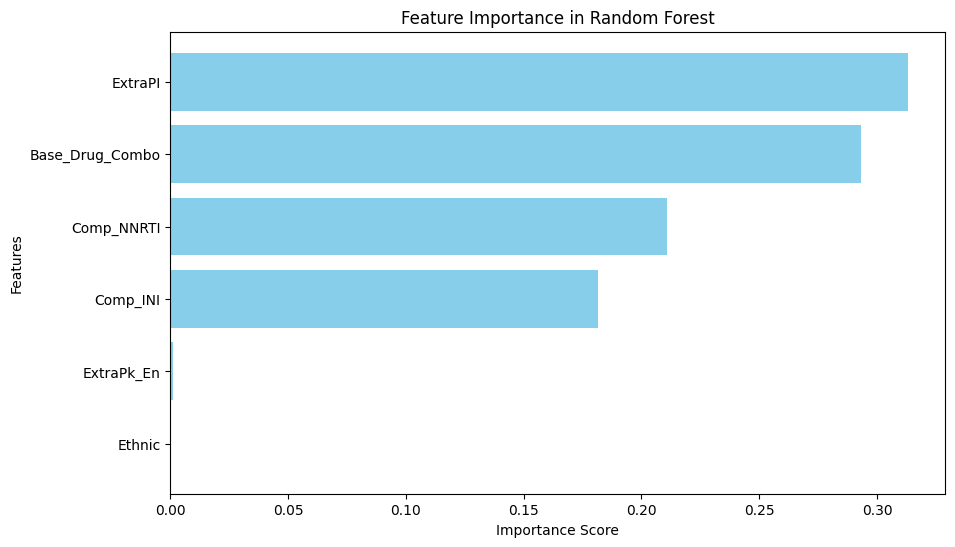

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained model
feature_importances = rf.feature_importances_

# Get feature names as a NumPy array
feature_names = np.array(asian_df.drop("All Criteria Met").columns)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Sorting indices in descending order
sorted_importances = feature_importances[sorted_indices]
sorted_features = feature_names[sorted_indices]  # Proper indexing

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()


In [42]:
black_df = joined_df.filter(pl.col('Ethnic') == 2)
train_df_black = train_df.filter(pl.col("Ethnic") == 2)
test_df_black = test_df.filter(pl.col("Ethnic") == 2)
train_df_black.write_csv("train_df_black.csv")
test_df_black.write_csv("test_df_black.csv")

In [43]:
import polars as pl
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(black_df["All Criteria Met"].to_numpy())  # Convert to NumPy and encode

# Convert features to NumPy
X = black_df.drop("All Criteria Met").to_numpy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Decode predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.7592


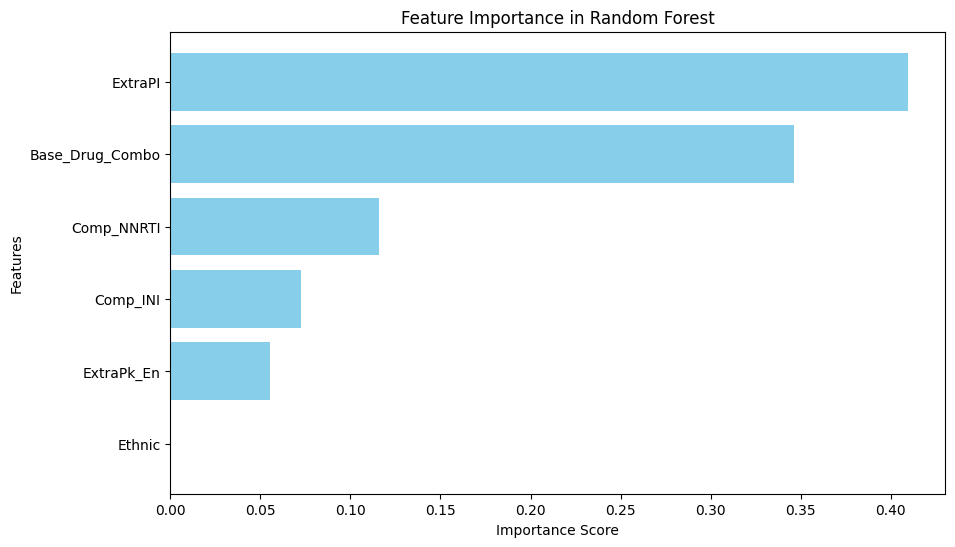

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained model
feature_importances = rf.feature_importances_

# Get feature names as a NumPy array
feature_names = np.array(black_df.drop("All Criteria Met").columns)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Sorting indices in descending order
sorted_importances = feature_importances[sorted_indices]
sorted_features = feature_names[sorted_indices]  # Proper indexing

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()


In [45]:
white_df = joined_df.filter(pl.col("Ethnic") == 3)
train_df_white = train_df.filter(pl.col("Ethnic") == 3)
test_df_white = test_df.filter(pl.col("Ethnic") == 3)
train_df_white.write_csv("train_df_white.csv")
test_df_white.write_csv("test_df_white.csv")

In [46]:
import polars as pl
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

white_df = white_df.drop('Ethnic')

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(white_df["All Criteria Met"].to_numpy())  # Convert to NumPy and encode

# Convert features to NumPy
X = white_df.drop("All Criteria Met").to_numpy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Decode predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.7000


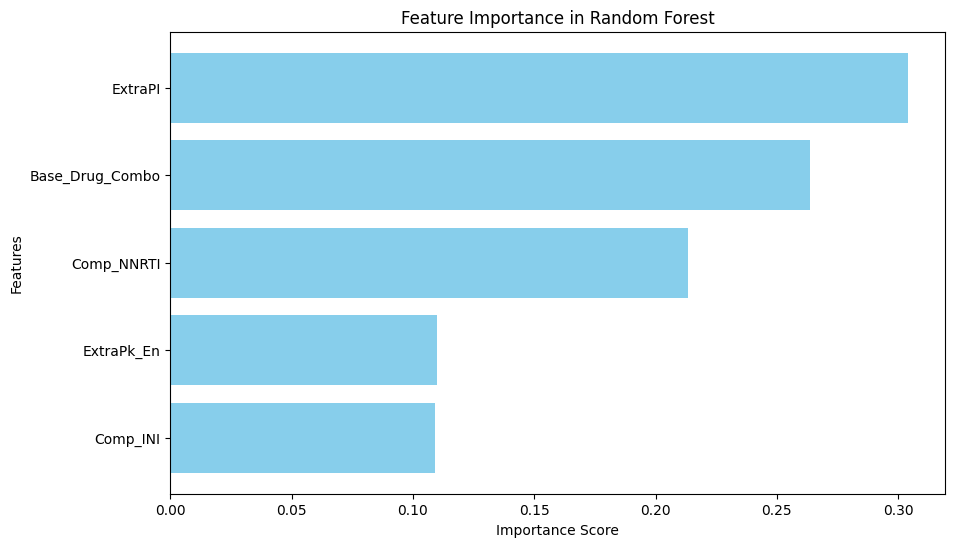

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained model
feature_importances = rf.feature_importances_

# Get feature names as a NumPy array
feature_names = np.array(white_df.drop("All Criteria Met").columns)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Sorting indices in descending order
sorted_importances = feature_importances[sorted_indices]
sorted_features = feature_names[sorted_indices]  # Proper indexing

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()


In [48]:
other_df = joined_df.filter(pl.col("Ethnic") == 4)
train_df_other = train_df.filter(pl.col("Ethnic") == 4)
test_df_other = test_df.filter(pl.col("Ethnic") == 4)
train_df_other.write_csv("train_df_other.csv")
test_df_other.write_csv("test_df_other.csv")

In [49]:
import polars as pl
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(other_df["All Criteria Met"].to_numpy())  # Convert to NumPy and encode

# Convert features to NumPy
X = other_df.drop("All Criteria Met").to_numpy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Decode predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.8179


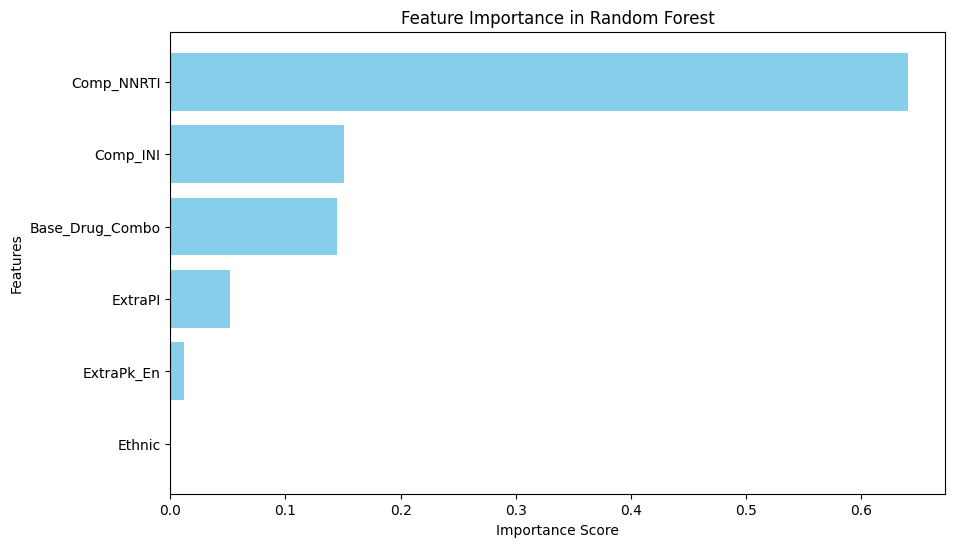

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained model
feature_importances = rf.feature_importances_

# Get feature names as a NumPy array
feature_names = np.array(other_df.drop("All Criteria Met").columns)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Sorting indices in descending order
sorted_importances = feature_importances[sorted_indices]
sorted_features = feature_names[sorted_indices]  # Proper indexing

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()


In [1]:
import numpy as np

# Define features (X) and target (y)

joined_df_pd = joined_df.toPandas()  

# Select categorical columns
categorical_cols = ["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"]

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# Fit-transform the categorical data
X_encoded = encoder.fit_transform(joined_df_pd[categorical_cols])

# Convert to NumPy array
X = X_encoded
#X = joined_df.select(["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"]).to_numpy()
y = joined_df.select("All Criteria Met").to_numpy().flatten()  # Convert to 1D array


NameError: name 'joined_df' is not defined

In [53]:
from sklearn.linear_model import LogisticRegression

# Create and train model
model = LogisticRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Model accuracy
accuracy = model.score(X, y)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6986


In [54]:
from sklearn.metrics import recall_score
sensitivity = recall_score(y, predictions)
print(f"Sensitivity: {sensitivity:.4f}")


Sensitivity: 0.2677


In [56]:
# # Create a dictionary mapping features to coefficients
# feature_coefficients = dict(zip(feature_names, coefficients))

# # Print the coefficients for each feature
# for feature, coef in feature_coefficients.items():
#     print(f"{feature}: {coef}")


In [60]:
# # Creating the dataset from the provided data
# data = {
#     "Patient_Count": [
#         68523, 51366, 48237, 36645, 26628, 24906, 19677, 17703, 15477, 
#         15057, 12096, 12012, 8757, 8652, 7098, 7035, 6615, 6594, 6468, 6300
#     ],
#     "Suppression_Category": [
#         "Moderate Suppression", "Moderate Suppression", "Moderate Suppression", 
#         "Moderate Suppression", "Moderate Suppression", "Slow Suppression", 
#         "Fast Suppression", "Moderate Suppression", "Moderate Suppression", 
#         "Moderate Suppression", "Moderate Suppression", "Slow Suppression", 
#         "Moderate Suppression", "Moderate Suppression", "Moderate Suppression", 
#         "Moderate Suppression", "Moderate Suppression", "Fast Suppression", 
#         "Fast Suppression", "Fast Suppression"
#     ]
# }

# # Creating a DataFrame
# df = pd.DataFrame(data)

# # Grouping the data by Suppression_Category and summing the patient counts
# grouped_data = df.groupby("Suppression_Category")["Patient_Count"].sum().reset_index()




                                                        2024-12-31  \
Treasury Shares Number                                         NaN   
Ordinary Shares Number                                2534487662.0   
Share Issued                                          2534487662.0   
Total Debt                                           49060000000.0   
Tangible Book Value                                 161068000000.0   
Invested Capital                                    211463000000.0   
Working Capital                                      66449000000.0   
Net Tangible Assets                                 161068000000.0   
Capital Lease Obligations                            20234000000.0   
Common Stock Equity                                 182637000000.0   
Total Capitalization                                211463000000.0   
Total Equity Gross Minority Interest                182637000000.0   
Stockholders Equity                                 182637000000.0   
Gains Losses Not Aff